In [1]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import networkx as nx
# 将图表设置成矢量图格式显示
% config InlineBackend.figure_format = 'svg'
# 创建有向图
G=nx.DiGraph()
# 有向图之间边的关系
edges = [("A","B"),("A","C"),("A","D"),("B","A"),("B","D"),("C","A"),("D","B"),("D","C")]
for edge in edges:
    G.add_edge(edge[0],edge[1])
page_rank_list=nx.pagerank(G,alpha=1) # alpha 是默认阻尼 0.85
print("pagerang 值是：",page_rank_list)

pagerang 值是： {'A': 0.33333396911621094, 'B': 0.22222201029459634, 'C': 0.22222201029459634, 'D': 0.22222201029459634}


我们通过 Network 创建了一个有向图之后，设置了节点之间的边，然后使用 PageRank 函数，就可以得到节点 PR 值。

整个数据集由三个文件组成：Aliases.csv，Email.csv，Person.csv，其中 Emails 文件记录了所有公开邮件的内容，发送者和接收者的信息。Persons 整个文件统计了邮件中所有任务的姓名和对应的 ID。因为姓名存在别名的情况，为了将邮件中的任务进行统一，我们还需要 Aliases 文件来查询别名和人物的对应关系。

In [9]:
# 用 PageRank 挖掘希拉里邮件中的重要任务关系

# 数据加载
emails = pd.read_csv("./Data/Emails.csv")

# 读取别名文件
file = pd.read_csv("./Data/Aliases.csv")
aliases = {}
for index,row in file.iterrows():
    aliases[row['Alias']] = row['PersonId']
# print(aliases)

# 读取人名文件
file = pd.read_csv("./Data/Persons.csv")
persons={}
for index,row in file.iterrows():
    persons[row['Id']]=row['Name']
#print(persons)

因为邮件中存在别名的情况，因此我们需要统一人物的名称。

In [5]:
def unify_name(name):
    # 姓名统一小写
    name=str(name).lower()
    # 去掉 ，和 @ 后面的内容
    name = name.replace(",","").split("@")[0]
    # 别名转换
    if name in aliases.keys():
        return persons[aliases[name]]
    return name

设置 show_graph 函数将网络图可视化，NetworkX 提供了多种可视化布局，这里我使用 spring_layout 布局，也就是呈中心放射状。

In [ ]:
# 画网络图
def show_graph(graph,layout='spring_layout'):
    # 使用 Spring Layout 布局，类似中心放射状
    if layout =='circular_layout':
        positions=nx.circular_layout(graph)
    else:
        positions=nx.spring_layout(graph)
    
    # 设置网络图中的节点大小，大小与 pagerank 值相关，因为 pagerank 值很小所以需要 *20000
    nodesize = [x['pagerank']*2000 for v,x in graph.node(data=True)]
    # 设置网络图中的边长度
    edgesize = [np.sqrt(e[2]['weight']) for e in graph.edges(data=True)]
    # 绘制节点
    nx.draw_networkx_nodes(graph,positions,node_size=nodesize,alpha=0.4)
    # 绘制边
    nx.draw_networkx_edges(graph,positions,edge_size = edgesize,alpha=0.2)
    # 绘制节点的label
    nx.draw_networkx_labels(graph,positions,font_size=10)
    plt.show()

将寄件人和收件人姓名进行规范化

In [6]:
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)
emails.MetadataTo = emails.MetadataTo.apply(unify_name)

邮件的发送者和接收者之间的邮件往来可能不止一次，我们需要用两者之间的邮件往来的次数计算这两者之间的边的权重。

In [7]:
 edge_weight_temp = defaultdict(list)
for row in zip(emails.MetadataFrom,emails.MetadataTo,emails.RawText):
    temp = (row[0],row[1])
    if temp not in edge_weight_temp:
        edge_weight_temp[temp]=1
    else:
        edge_weight_temp[temp]=edge_weight_temp[temp]+1

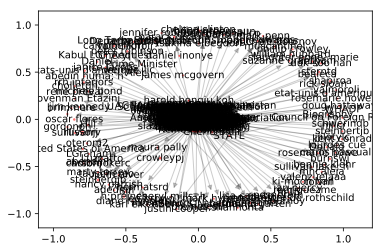

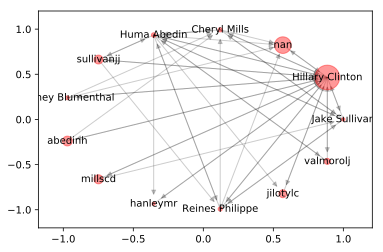

In [8]:
# 转化格式（from,to）,weight => from,to,weight
edges_weights = [(key[0], key[1], val) for key, val in edge_weight_temp.items()]

# 创建一个有向图
graph = nx.DiGraph()

# 设置有向图中的路径及权重（from，to，weight）
graph.add_weighted_edges_from(edges_weights)

# 计算每个节点(人)的 PR 值，并作为节点的 PageRank 属性
pagerank=nx.pagerank(graph)

# 将 pagerank 数值作为节点的属性
nx.set_node_attributes(graph,name='pagerank',values=pagerank)

# 画网络图
show_graph(graph)

# 将完整的图谱进行精简
# 设置 PR 值的阈值，筛选大雨阈值的重要核心节点
pagerank_threshold = 0.005

# 复制一份计算好的网络图
small_graph =graph.copy()

# 剪掉 PR 值小于 pagerank_threshold 的节点
for n,p_rank in graph.nodes(data=True):
    if p_rank['pagerank'] < pagerank_threshold:
        small_graph.remove_node(n)

# 画网络图 ，采用 circular_layout 布局让筛选出来的点组成一个圆
show_graph(small_graph,'circular_layout')